# Задание 1

In [1]:
from fake_useragent import UserAgent
import urllib.request

ua = UserAgent()


url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
headers ={ "User-Agent" : str(ua.chrome) }
req = urllib.request.Request(url, None, headers)
fp = urllib.request.urlopen(req)

text = fp.read()
text = text.decode("utf8")

fp.close()

In [2]:
from bs4 import BeautifulSoup
import numpy as np


soup = BeautifulSoup(text, 'html.parser')

unhandled_stations = soup.find("table", class_="wikitable sortable").tbody.find_all("tr")[1:]
# for group in groups_by_letters:
#     for scientist in group.find_all('a'):
#         scientists_names.append(scientist["title"])
#         scientists_links.append("https://en.wikipedia.org/" + scientist["href"])



In [3]:
import re

In [4]:
def StationFormatter(station):
    '''Example: Transfer for #1 Sokolnicheskaya line at Bulvar Rokossovskogo'''
    station = re.findall('(\d+\w*) (.*)', station)[0]
    line = station[0]
    name = station[1].split('at ')[1].split(' via')[0].split(')')[0]
    
    if line == '4A' or line == '11A':
        return None
    return {'name': name, 'line': line}
    

def ExtractStationData(station_tag):
    fields_tags = station_tag.find_all("td")
    name = fields_tags[0].a['title'].split(' (')[0]
    line = re.findall('(\d+\w*)', station_tag.th.a["title"])[0]
    
    
    opened = fields_tags[3].text.replace("\n", "")
    coords = fields_tags[-1]
    coords = np.array(coords.span.a.find(class_='vcard').find(class_='geo').contents[0].split(';'), dtype=float)
    latitude = float(coords[0])
    longtitude = float(coords[1])
    
    transfers = []
    for transfer in fields_tags[2].find_all('span'):
#         transfers.append(StationFormatter())
        span = transfer.span
        if span:
            transfer = StationFormatter(span['title'])
            if transfer:
                transfers.append(transfer)
    
    if line == '4A' or line == '11A':
        return None
        
    return {'name': name, 'line': line, 'opened': opened, 
            'latitude': latitude, 'longtitude': longtitude, 'connects': [], 'transfers': transfers}

In [5]:
stations = []

j = 0
for i in range(len(unhandled_stations)):
    curr_station = ExtractStationData(unhandled_stations[i])
    if curr_station:
        stations.append(curr_station)

        if (j > 0) and (stations[j]['line'] == stations[j - 1]['line']):
            stations[j]['connects'].append(stations[j - 1]['name'])
            stations[j - 1]['connects'].append(stations[j]['name'])
        j += 1

In [6]:
import yaml

with open(r'Stations.yaml', 'w') as file:
    documents = yaml.dump(stations, file)

# Задание 2

In [7]:
import configparser

config = configparser.ConfigParser()
# config.readfp(open(r'config.txt'))
config.read_file(open('config.txt'))
v = float(config.get('config', 'v'))
t_tr = float(config.get('config', 't_tr'))
t_st = float(config.get('config', 't_st'))
transfer_time_file = config.get('config', 'transfer_time_file')

In [8]:
v, t_tr, t_st, transfer_time_file

(100.0, 0.01, 5.0, 'transfers_time.txt')

In [9]:
from math import acos, sin, cos

In [10]:
def CountConnectTime(v, t_st, longtitude1, latitude1, longtitude2, latitude2):
    return acos(sin(latitude1)*sin(latitude2)+cos(latitude1)*cos(latitude2)*cos(longtitude2-longtitude1))*6371 / v + t_st 

In [11]:
specified_transfer_times = {}

with open(transfer_time_file) as stream:    
    lines = stream.readlines()
    for line in lines:
        curr_transf = line.split('; ')
        time = float(curr_transf[2])
        first_line = curr_transf[0]
        second_line = curr_transf[1]
        specified_transfer_times[(first_line, second_line)] = time
        specified_transfer_times[(second_line, first_line)] = time

In [12]:
stations = []

with open(r'Stations.yaml') as stream:    
    stations = yaml.safe_load(stream)
    

    

    
stations_counter = 0
station_nums = {}




# numerate stations
for station in stations:
#     print(station['line'])
    name = station['name'] + ', ' + station['line']
    stations_counter += 1
    station_nums[name] = stations_counter

# add edges
edges = []


for i in range(stations_counter):
    station = stations[i]
    first_name = station['name'] + ', ' + station['line']
    line = station['line']
    
    for second_station in station['transfers']:
        second_name = second_station['name'] + ', ' + second_station['line']
        if (first_name, second_name) in specified_transfer_times:
            edges.append((first_name, second_name, specified_transfer_times[(first_name, second_name)]))
        else:
            edges.append((first_name, second_name, t_tr))
    
    if i and line == stations[i - 1]['line']:
        second_name = stations[i - 1]['name'] + ', ' + stations[i - 1]['line']
        longtitude1, latitude1 = station['longtitude'], station['latitude']
        longtitude2, latitude2 = stations[i - 1]['longtitude'], stations[i - 1]['latitude']
        edges.append((first_name, second_name, 
                      CountConnectTime(v, t_st, longtitude1, latitude1, longtitude2, latitude2)))
    
    if i < stations_counter - 1 and line == stations[i + 1]['line']:
        second_name = stations[i + 1]['name'] + ', ' + stations[i + 1]['line']
        longtitude1, latitude1 = station['longtitude'], station['latitude']
        longtitude2, latitude2 = stations[i + 1]['longtitude'], stations[i + 1]['latitude']
        edges.append((first_name, second_name, 
                      CountConnectTime(v, t_st, longtitude1, latitude1, longtitude2, latitude2))) 

In [13]:
with open("SubWays.tgf", "w") as fp:
    for station in station_nums:
#         print(station)
        fp.write(str(station_nums[station]) + " \"" + str(station) + "\"" + "\n")
    
    fp.write("#\n")
    
    for edge in edges:
        fp.write(str(station_nums[edge[0]]) + " " + str(station_nums[edge[1]]) + " " + str(edge[2]) + "\n")
          
    

# Задание 3

In [14]:
import numpy as np

In [15]:
lines = []
with open("SubWays.tgf", "r") as fp:
    lines = fp.readlines()

In [16]:
N = lines.index('#\n')
W = np.ones((N, N)) * np.inf

for i in range(N + 1, len(lines)):
    edge = lines[i].split()
#     print(int(edge[0]) - 1, int(edge[1]) - 1)
    W[int(edge[0]) - 1][int(edge[1]) - 1] = float(edge[2])

for i in range(N):
    W[i][i] = 0.

In [17]:
W

array([[0.        , 5.86030265,        inf, ...,        inf,        inf,
               inf],
       [5.86030265, 0.        , 6.46627881, ...,        inf,        inf,
               inf],
       [       inf, 6.46627881, 0.        , ...,        inf,        inf,
               inf],
       ...,
       [       inf,        inf,        inf, ..., 0.        , 5.90713353,
               inf],
       [       inf,        inf,        inf, ..., 5.90713353, 0.        ,
        6.14572063],
       [       inf,        inf,        inf, ...,        inf, 6.14572063,
        0.        ]])

In [18]:
d = W.copy()

for k in range(N):
    for i in range(N):
        for j in range(N):
            d[i][j] = min(d[i][j], d[i][k] + d[k][j])




In [19]:
d.mean() 

85.45546463444983

In [20]:
mean_times = d.mean(axis = 1)

In [21]:
from matplotlib.pyplot import hist

(array([118.,  74.,  46.,  17.,   5.,   3.,   3.,   4.,   4.,   8.]),
 array([ 51.65209152,  69.83133799,  88.01058447, 106.18983094,
        124.36907741, 142.54832388, 160.72757036, 178.90681683,
        197.0860633 , 215.26530978, 233.44455625]),
 <BarContainer object of 10 artists>)

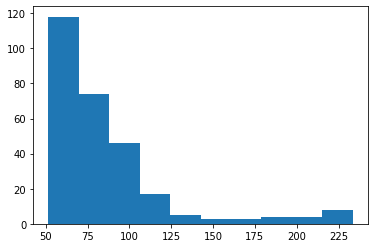

In [22]:
hist(mean_times)

# Задание 4

In [23]:
changes_file = 'wind_of_change.txt'

In [24]:
changes = []
with open(changes_file, "r") as fp:
    changes = fp.readlines()

In [25]:
stations2 = stations.copy()
for change in changes:
    first_station, new_second_station = change.split('; ')
    new_second_station = new_second_station.rstrip("\n")
#     print(first_station)
    first_idx = station_nums[first_station] - 1
    new_second_idx = station_nums[new_second_station] - 1
    
    prev_transfers = stations[first_idx]['transfers']
    for prev_transfer in prev_transfers:
        transfer_idx = station_nums[prev_transfer['name'] + ', ' + prev_transfer['line']] - 1
#         print(stations[transfer_idx])
        stations[transfer_idx]['transfers'].remove({'line': '11', 'name': first_station.split(', ')[0]})
        
    stations[first_idx]['transfers'] = [
                                {'line': new_second_station.split(', ')[1], 
                                 'name': new_second_station.split(', ')[0]}
                                        ]
    stations[new_second_idx]['transfers'].append(
                                {'line': first_station.split(', ')[1], 
                                 'name': first_station.split(', ')[0]}
    )
    
    stations[first_idx]['latitude'] = stations[new_second_idx]['latitude']
    stations[first_idx]['longtitude'] = stations[new_second_idx]['latitude']

In [26]:
# add edges
edges = []


for i in range(stations_counter):
    station = stations[i]
    first_name = station['name'] + ', ' + station['line']
    line = station['line']
    
    for second_station in station['transfers']:
        second_name = second_station['name'] + ', ' + second_station['line']
        if (first_name, second_name) in specified_transfer_times:
            edges.append((first_name, second_name, specified_transfer_times[(first_name, second_name)]))
        else:
            edges.append((first_name, second_name, t_tr))
    
    if i and line == stations[i - 1]['line']:
        second_name = stations2[i - 1]['name'] + ', ' + stations2[i - 1]['line']
        longtitude1, latitude1 = station['longtitude'], station['latitude']
        longtitude2, latitude2 = stations2[i - 1]['longtitude'], stations2[i - 1]['latitude']
        edges.append((first_name, second_name, 
                      CountConnectTime(v, t_st, longtitude1, latitude1, longtitude2, latitude2)))
    
    if i < stations_counter - 1 and line == stations2[i + 1]['line']:
        second_name = stations[i + 1]['name'] + ', ' + stations[i + 1]['line']
        longtitude1, latitude1 = station['longtitude'], station['latitude']
        longtitude2, latitude2 = stations[i + 1]['longtitude'], stations[i + 1]['latitude']
        edges.append((first_name, second_name, 
                      CountConnectTime(v, t_st, longtitude1, latitude1, longtitude2, latitude2))) 

In [32]:
edges

[('Bulvar Rokossovskogo, 1', 'Bulvar Rokossovskogo, 14', 470.0),
 ('Bulvar Rokossovskogo, 1', 'Cherkizovskaya, 1', 5.860302649567219),
 ('Cherkizovskaya, 1', 'Lokomotiv, 14', 240.0),
 ('Cherkizovskaya, 1', 'Bulvar Rokossovskogo, 1', 5.860302649567219),
 ('Cherkizovskaya, 1', 'Preobrazhenskaya Ploshchad, 1', 6.466278807490389),
 ('Preobrazhenskaya Ploshchad, 1', 'Cherkizovskaya, 1', 6.466278807490389),
 ('Preobrazhenskaya Ploshchad, 1', 'Sokolniki, 1', 6.686639136800265),
 ('Sokolniki, 1', 'Preobrazhenskaya Ploshchad, 1', 6.686639136800265),
 ('Sokolniki, 1', 'Krasnoselskaya, 1', 5.811936260883347),
 ('Krasnoselskaya, 1', 'Sokolniki, 1', 5.811936260883347),
 ('Krasnoselskaya, 1', 'Komsomolskaya, 1', 5.592269831407442),
 ('Komsomolskaya, 1', 'Komsomolskaya, 5', 0.01),
 ('Komsomolskaya, 1', 'Krasnoselskaya, 1', 5.592269831407442),
 ('Komsomolskaya, 1', 'Krasnye Vorota, 1', 5.5265779363798035),
 ('Krasnye Vorota, 1', 'Komsomolskaya, 1', 5.5265779363798035),
 ('Krasnye Vorota, 1', 'Chistye 

In [35]:
W2 = np.ones((N, N)) * np.inf

for edge in edges:
    first_idx = station_nums[edge[0]] - 1
    second_idx = station_nums[edge[1]] - 1
    W2[first_idx][second_idx] = edge[2]
    
    
for i in range(N):
    W2[i][i] = 0.

In [37]:
d2 = W2.copy()

for k in range(N):
    for i in range(N):
        for j in range(N):
            d2[i][j] = min(d2[i][j], d2[i][k] + d2[k][j])




In [52]:
(d-d2).mean()

1.8748759954775234

In [51]:
import pandas as pd
delta = d2.mean(axis=0) - d.mean(axis=0)
names = []
vals = []
for i in range(len(stations2)):
    names.append(stations2[i]['name'])
    vals.append(delta[i])
data = {'name': names, 'val': vals}
df = pd.DataFrame.from_dict(data)
df = df.sort_values('val', ascending=False)
df_html = df.to_html()

with open("Table of times.html", "w") as f_html:
    f_html.write(df_html)